In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [7]:
df=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['parcelid','rawcensustractandblock']] 
df['state']=df['rawcensustractandblock'].map(lambda u: str(u)[:2])
df=df.drop('rawcensustractandblock',axis=1).compute()
df=df.set_index('parcelid')
df.shape

(9463187, 1)

In [9]:
df['state'].value_counts()

39    3111391
37    2932874
06    1809321
36     829379
19     732280
na      47942
Name: state, dtype: int64

In [10]:
df=df[df['state']=='19']
df.shape

(732280, 1)

In [11]:
filename='tax_history_2007to2017_v2.parq'

In [12]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute().set_index("parcelid")

In [13]:
print data.shape
data=data.loc[df.index]
print data.shape

(84932226, 14)
(6222846, 14)


In [14]:
set(data.assessmentyear)

{2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}

In [15]:
years=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [16]:
data_dict={u:data[data['assessmentyear']==u] for u in 
           years}

In [17]:
for i in years:
    print i, data_dict[i].shape[0]

2007 536509
2008 579640
2009 545894
2010 545964
2011 593341
2012 663315
2013 511684
2014 492739
2015 731008
2016 656879
2017 365873


In [18]:
lst=[]
for i in years:
    lst.append(data_dict[i].isnull().mean())
tmpdf=pd.concat(lst,axis=1)
tmpdf.columns=years
tmpdf

2007      2008      2009      2010      2011  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.464468  0.495364  0.586775  0.451555  0.424853   
improvementmarketvalue      1.000000  0.935724  0.929734  0.988186  0.924896   
structuretaxvaluedollarcnt  0.502331  0.372597  0.388081  0.396559  0.372241   
totalassessedvalue          0.480268  0.350205  0.367009  0.369297  0.348365   
taxamount                   0.392562  0.482826  0.441331  0.393711  0.549726   
taxvaluedollarcnt           0.480268  0.350205  0.367009  0.369297  0.348365   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.482998  0.353785  0.373173  0.380065  0.358423   
taxdelinquencyyear          1.000000  1.000000  1.000000  1.000000  1.000000   
totalmarketvalue            1.000000  0.934345  0.929208  0.988135  0.924308   
improvementassessedvalue    0.502331  0.372597  0.388081  0.396559  0.372241   
landtaxvaluedollarcnt       0.482998  0.353785  0.373173  0.380065  0.358423   
landmarketvalue             1.000000  0.934763  0.932139  0.988239  0.924411   

                                2012      2013      2014      2015      2016  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.513981  0.426787  0.595839  0.503770  0.508964   
improvementmarketvalue      0.929267  0.922020  0.980341  0.891029  0.847981   
structuretaxvaluedollarcnt  0.320487  0.338207  0.286933  0.370733  0.344910   
totalassessedvalue          0.298945  0.337820  0.028471  0.046461  0.043145   
taxamount                   0.429068  0.411246  0.010760  0.009205  0.008381   
taxvaluedollarcnt           0.298945  0.323807  0.028400  0.046393  0.042688   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.308636  0.344369  0.284000  0.368906  0.345462   
taxdelinquencyyear          0.925651  0.534267  0.956328  0.964218  0.962940   
totalmarketvalue            0.927986  0.921620  0.980294  0.890622  0.847232   
improvementassessedvalue    0.320487  0.352026  0.293372  0.375101  0.349765   
landtaxvaluedollarcnt       0.308636  0.330391  0.277557  0.364583  0.340634   
landmarketvalue             0.928514  0.921794  0.980418  0.890962  0.849560   

                                2017  
assessmentyear              0.000000  
taxratecodearea             0.567905  
improvementmarketvalue      0.810155  
structuretaxvaluedollarcnt  0.338825  
totalassessedvalue          0.070754  
taxamount                   0.009798  
taxvaluedollarcnt           0.070754  
edition                     0.000000  
landassessedvalue           0.332017  
taxdelinquencyyear          0.966251  
totalmarketvalue            0.563745  
improvementassessedvalue    0.338825  
landtaxvaluedollarcnt       0.332017  
landmarketvalue             0.810560

In [19]:
def get_col(col):
    df=pd.concat([data_dict[i][col] for i in years],axis=1)
    df.columns=years
    return df

In [20]:
print "Are there ones whose tax is not null but taxvalue is null?"
a=get_col("taxamount")
b=get_col("taxvaluedollarcnt")

Are there ones whose tax is not null but taxvalue is null?


In [21]:
for year in years:
    aa=a.loc[:,year]
    bb=b.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    num=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    print year,num,ab.shape[0],float(num)/ab.shape[0]
    #break

2007 254935 732280 0.348138690119
2008 200372 732280 0.273627574152
2009 198303 732280 0.270802152182
2010 198935 732280 0.271665210029
2011 202850 732280 0.277011525646
2012 194416 732280 0.265494073305
2013 162175 732280 0.221465832742
2014 12958 732280 0.0176954170536
2015 30498 732280 0.0416480034959
2016 25607 732280 0.0349688643688
2017 24474 732280 0.0334216419949


In [22]:
print "how assesed values varies with market value?"
c=get_col('totalassessedvalue')
d=get_col('totalmarketvalue')

how assesed values varies with market value?


In [25]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 278841 0 0 536509 [ 0.52  0.    0.    0.48]
2008 338591 0 38056 579640 [ 0.584  0.     0.066  0.35 ]
2009 306901 0 38645 545894 [ 0.562  0.     0.071  0.367]
2010 337863 0 6478 545964 [ 0.619  0.     0.012  0.369]
2011 341731 0 44911 593341 [ 0.576  0.     0.076  0.348]
2012 417252 0 47768 663315 [ 0.629  0.     0.072  0.299]
2013 305891 7170 32936 511684 [ 0.598  0.014  0.064  0.324]
2014 469035 35 9675 492739 [ 0.952  0.     0.02   0.028]
2015 617138 49 79907 731008 [ 0.844  0.     0.109  0.046]
2016 528488 300 100050 656879 [ 0.805  0.     0.152  0.043]
2017 180372 0 159614 365873 [ 0.493  0.     0.436  0.071]


In [27]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

 2007 missing
2008 38056 0 0 579640 [ 0.066  0.     0.     1.   ]
2009 38645 0 0 545894 [ 0.071  0.     0.     1.   ]
2010 6478 0 0 545964 [ 0.012  0.     0.     1.   ]
2011 44911 0 0 593341 [ 0.076  0.     0.     1.   ]
2012 47768 0 0 663315 [ 0.072  0.     0.     1.   ]
2013 32936 180 700 511684 [ 0.064  0.005  0.021  0.973]
2014 9675 45 216 492739 [ 0.02   0.005  0.022  0.973]
2015 79907 392 3622 731008 [ 0.109  0.005  0.045  0.95 ]
2016 100050 140 879 656879 [ 0.152  0.001  0.009  0.99 ]
2017 159614 0 0 365873 [ 0.436  0.     0.     1.   ]


In [28]:
print """
    almost always equal  
"""


    almost always equal  



 look at their difference
2007 missing
2008 38056 0 [ 0.066  0.   ]


2009 38645 0 [ 0.071  0.   ]


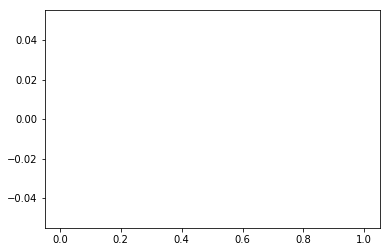

2010 6478 0 [ 0.012  0.   ]


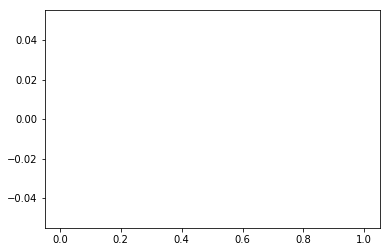

2011 44911 0 [ 0.076  0.   ]


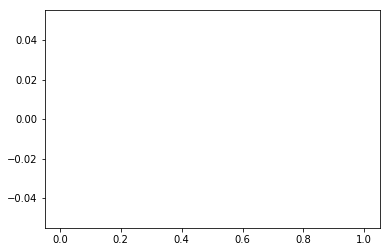

2012 47768 0 [ 0.072  0.   ]


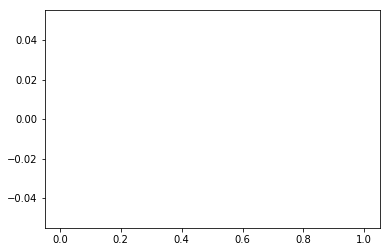

2013 32936 880 [ 0.064  0.027]


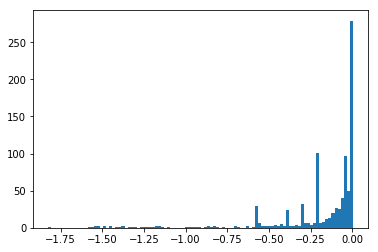

2014 9675 261 [ 0.02   0.027]


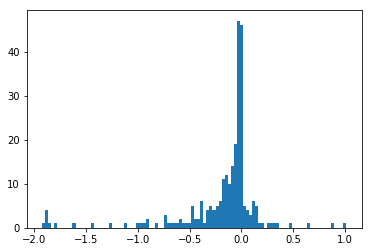

2015 79907 4014 [ 0.109  0.05 ]


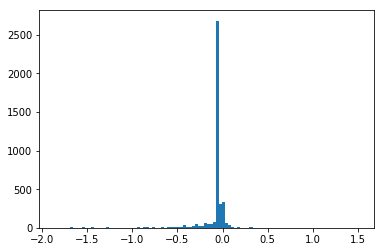

2016 100050 1019 [ 0.152  0.01 ]


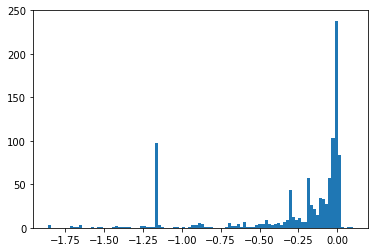

2017 159614 0 [ 0.436  0.   ]


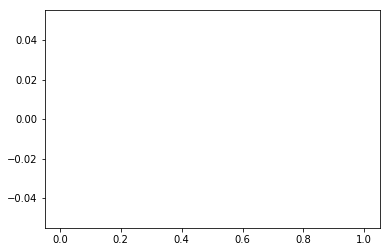

In [30]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [31]:
print """
    not have much difference
"""


    not have much difference



### landassessedvalue vs  landmarketvalue

In [32]:
print "how assesed values varies with market value?"
c=get_col('landassessedvalue')
d=get_col('landmarketvalue')

how assesed values varies with market value?


In [33]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 277376 0 0 536509 [ 0.517  0.     0.     0.483]
2008 336758 0 37814 579640 [ 0.581  0.     0.065  0.354]
2009 305136 0 37045 545894 [ 0.559  0.     0.068  0.373]
2010 332041 0 6421 545964 [ 0.608  0.     0.012  0.38 ]
2011 335824 0 44850 593341 [ 0.566  0.     0.076  0.358]
2012 411174 0 47418 663315 [ 0.62   0.     0.071  0.309]
2013 302611 7152 32865 511684 [ 0.591  0.014  0.064  0.33 ]
2014 346327 3175 6474 492739 [ 0.703  0.006  0.013  0.278]
2015 384787 3160 76548 731008 [ 0.526  0.004  0.105  0.365]
2016 334303 3172 95649 656879 [ 0.509  0.005  0.146  0.341]
2017 175086 0 69311 365873 [ 0.479  0.     0.189  0.332]


In [35]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

 2007 missing
2008 37814 0 0 579640 [ 0.065  0.     0.     1.   ]
2009 37045 0 0 545894 [ 0.068  0.     0.     1.   ]
2010 6421 0 0 545964 [ 0.012  0.     0.     1.   ]
2011 44850 0 0 593341 [ 0.076  0.     0.     1.   ]
2012 47418 0 0 663315 [ 0.071  0.     0.     1.   ]
2013 32865 113 334 511684 [ 0.064  0.003  0.01   0.986]
2014 6474 0 0 492739 [ 0.013  0.     0.     1.   ]
2015 76548 113 317 731008 [ 0.105  0.001  0.004  0.994]
2016 95649 121 324 656879 [ 0.146  0.001  0.003  0.995]
2017 69311 0 0 365873 [ 0.189  0.     0.     1.   ]


In [36]:
print """
    always equal 
"""


    always equal 



look at their difference
2007 missing
2008 37814 0 [ 0.065  0.   ]


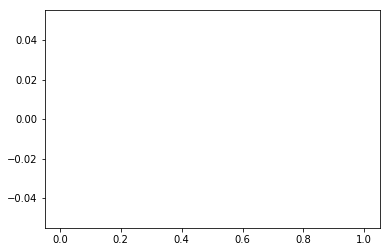

2009 37045 0 [ 0.068  0.   ]


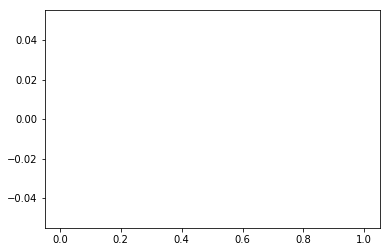

2010 6421 0 [ 0.012  0.   ]


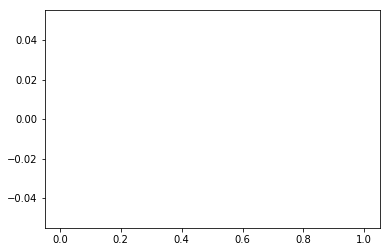

2011 44850 0 [ 0.076  0.   ]


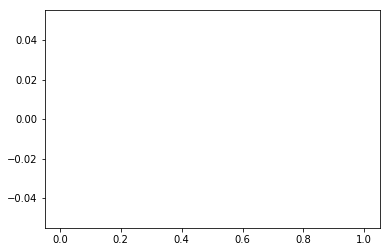

2012 47418 0 [ 0.071  0.   ]


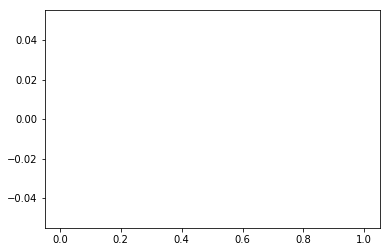

2013 32865 447 [ 0.064  0.014]


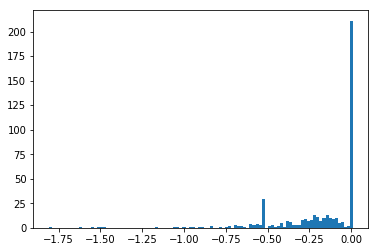

2014 6474 0 [ 0.013  0.   ]


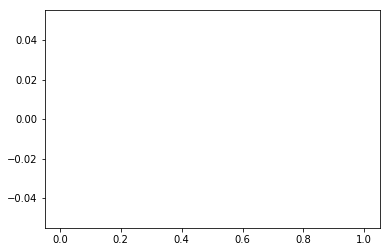

2015 76548 430 [ 0.105  0.006]


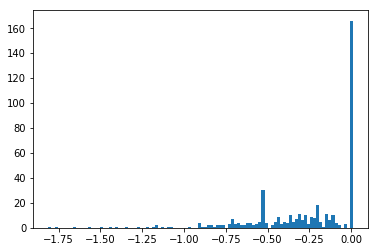

2016 95649 445 [ 0.146  0.005]


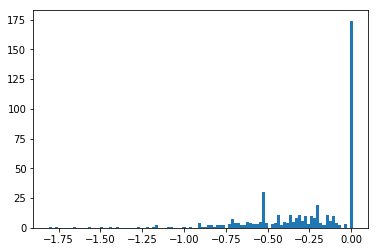

2017 69311 0 [ 0.189  0.   ]


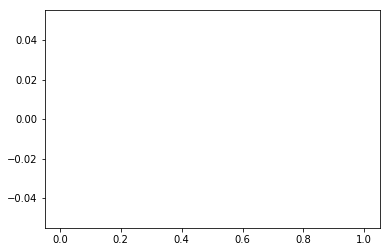

In [37]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [38]:
print """
    almost same
"""


    almost same



### landassessedvalue vs  landmarketvalue

In [39]:
print "how assesed values varies with market value?"
c=get_col('improvementassessedvalue')
d=get_col('improvementmarketvalue')

how assesed values varies with market value?


In [40]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 267004 0 0 536509 [ 0.498  0.     0.     0.502]
2008 326411 0 37257 579640 [ 0.563  0.     0.064  0.373]
2009 295685 0 38358 545894 [ 0.542  0.     0.07   0.388]
2010 323007 0 6450 545964 [ 0.592  0.     0.012  0.397]
2011 327913 0 44562 593341 [ 0.553  0.     0.075  0.372]
2012 403813 0 46918 663315 [ 0.609  0.     0.071  0.32 ]
2013 298728 7071 32830 511684 [ 0.584  0.014  0.064  0.338]
2014 341669 3173 6514 492739 [ 0.693  0.006  0.013  0.287]
2015 380340 3193 76466 731008 [ 0.52   0.004  0.105  0.371]
2016 330457 3189 96669 656879 [ 0.503  0.005  0.147  0.345]
2017 172447 0 69459 365873 [ 0.471  0.     0.19   0.339]


In [41]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 missing
2008 37257 0 0 579640 [ 0.064  0.     0.     1.   ]
2009 38358 0 0 545894 [ 0.07  0.    0.    1.  ]
2010 6450 0 0 545964 [ 0.012  0.     0.     1.   ]
2011 44562 0 0 593341 [ 0.075  0.     0.     1.   ]
2012 46918 0 0 663315 [ 0.071  0.     0.     1.   ]
2013 32830 158 443 511684 [ 0.064  0.005  0.013  0.982]
2014 6514 0 0 492739 [ 0.013  0.     0.     1.   ]
2015 76466 114 458 731008 [ 0.105  0.001  0.006  0.993]
2016 96669 114 566 656879 [ 0.147  0.001  0.006  0.993]
2017 69459 0 0 365873 [ 0.19  0.    0.    1.  ]


In [42]:
print """
    always equal  
"""


    always equal  



look at their difference
2007 missing
2008 37257 0 [ 0.064  0.   ]


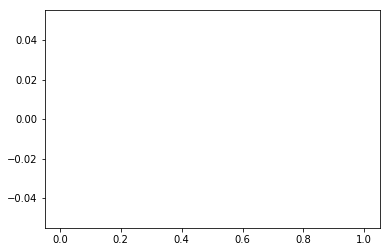

2009 38358 0 [ 0.07  0.  ]


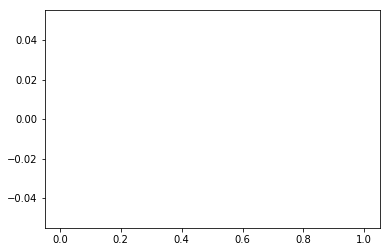

2010 6450 0 [ 0.012  0.   ]


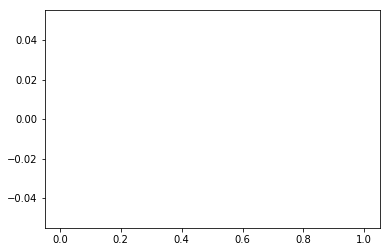

2011 44562 0 [ 0.075  0.   ]


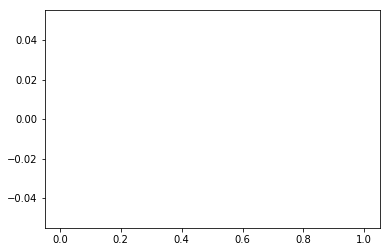

2012 46918 0 [ 0.071  0.   ]


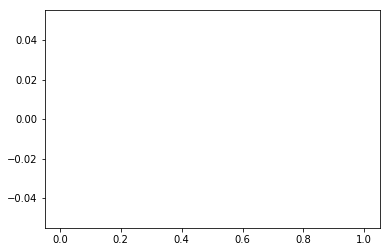

2013 32830 601 [ 0.064  0.018]


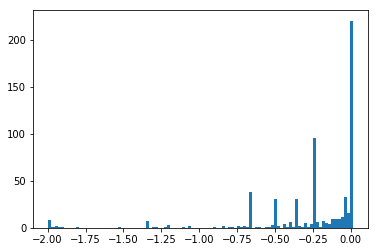

2014 6514 0 [ 0.013  0.   ]


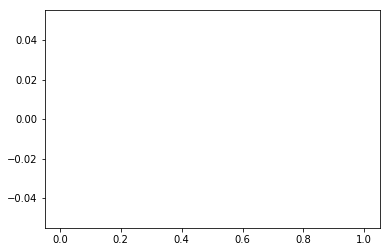

2015 76466 572 [ 0.105  0.007]


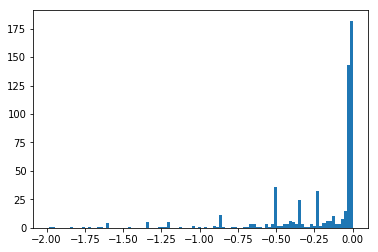

2016 96669 680 [ 0.147  0.007]


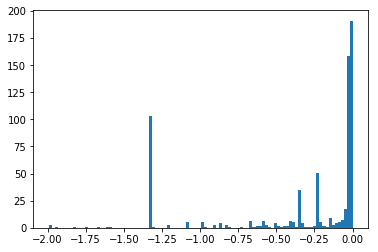

2017 69459 0 [ 0.19  0.  ]


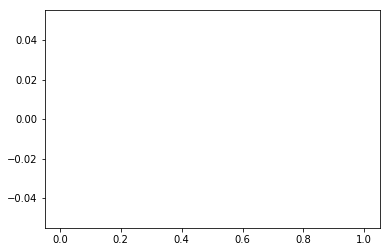

In [43]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [44]:
print """
   almost same
"""


   almost same



### land vs total

In [45]:
c=get_col('improvementassessedvalue')
d=get_col('landassessedvalue')

In [46]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],4)

2007 1465 11837 265539 536509 [ 0.0027  0.0221  0.4949  0.4803]
2008 1962 12866 361706 579640 [ 0.0034  0.0222  0.624   0.3504]
2009 3266 11404 330777 545894 [ 0.006   0.0209  0.6059  0.3672]
2010 1891 10896 327566 545964 [ 0.0035  0.02    0.6     0.3766]
2011 1970 10169 370505 593341 [ 0.0033  0.0171  0.6244  0.3551]
2012 2422 10283 448309 663315 [ 0.0037  0.0155  0.6759  0.305 ]
2013 3348 7266 328210 511684 [ 0.0065  0.0142  0.6414  0.3378]
2014 2902 7520 345281 492739 [ 0.0059  0.0153  0.7007  0.2781]
2015 3286 7815 453520 731008 [ 0.0045  0.0107  0.6204  0.3644]
2016 3008 5834 424118 656879 [ 0.0046  0.0089  0.6457  0.3409]
2017 1758 4249 240148 365873 [ 0.0048  0.0116  0.6564  0.3272]


In [47]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 265539 [ 0.495] 0.0 0.0


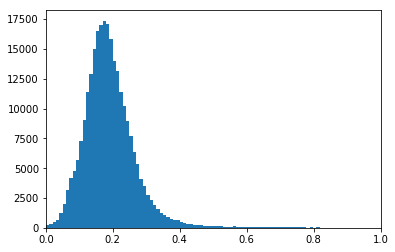

2008 361706 [ 0.624] 0.0 0.0


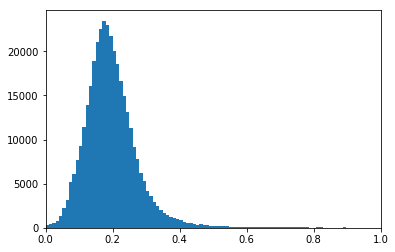

2009 330777 [ 0.606] 0.0 0.0


2010 327566 [ 0.6] 0.0 0.0


2011 370505 [ 0.624] 0.0 0.0


2012 448309 [ 0.676] 0.0 0.0


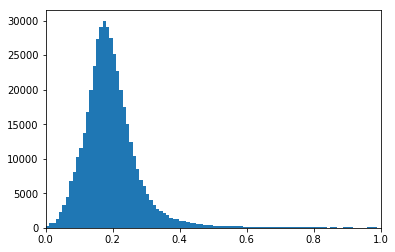

2013 328210 [ 0.641] 0.0 0.0


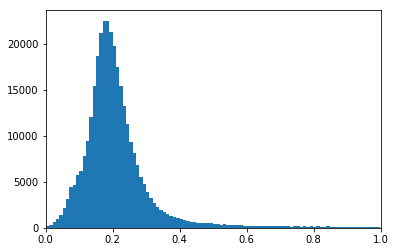

2014 345281 [ 0.701] 0.0 0.0


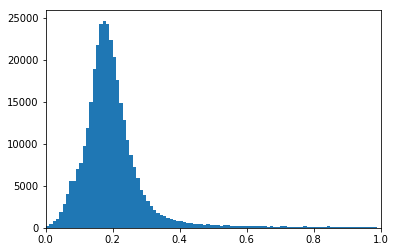

2015 453520 [ 0.62] 0.0 0.0


2016 424118 [ 0.646] 0.0 0.0


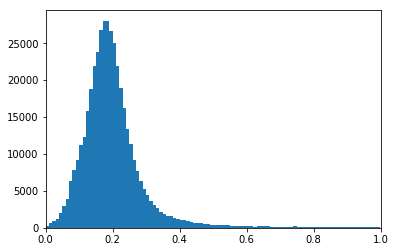

2017 240148 [ 0.656] 0.0 0.0


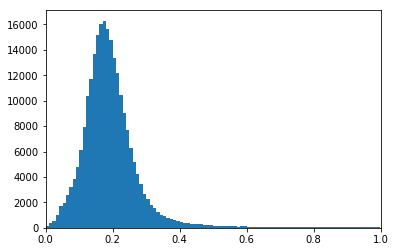

In [48]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [49]:
print """
    There are negative values for 2015. peak for the ratio is 0.2.
"""


    There are negative values for 2015. peak for the ratio is 0.2.



### land vs total

In [50]:
c=get_col(u'improvementmarketvalue')
d=get_col(u'landmarketvalue')

In [52]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 0 0 0 536509 [ 0.  0.  0.  1.]
2008 242 799 37015 579640 [ 0.     0.001  0.064  0.934]
2009 1600 287 36758 545894 [ 0.003  0.001  0.067  0.929]
2010 57 28 6393 545964 [ 0.     0.     0.012  0.988]
2011 61 349 44501 593341 [ 0.     0.001  0.075  0.924]
2012 350 850 46568 663315 [ 0.001  0.001  0.07   0.928]
2013 89 205 39812 511684 [ 0.     0.     0.078  0.922]
2014 61 23 9626 492739 [ 0.    0.    0.02  0.98]
2015 248 297 79411 731008 [ 0.     0.     0.109  0.891]
2016 1158 121 98700 656879 [ 0.002  0.     0.15   0.848]
2017 545 397 68914 365873 [ 0.001  0.001  0.188  0.809]


In [53]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 0 [ 0.] nan nan


/home/bo/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


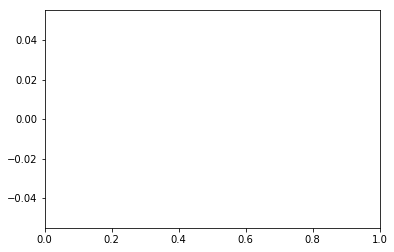

2008 37015 [ 0.064] 0.0 0.0


2009 36758 [ 0.067] 0.0 0.0


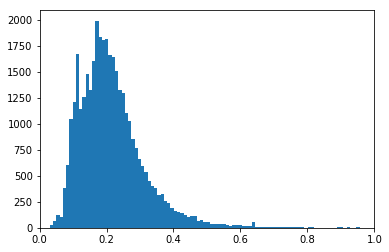

2010 6393 [ 0.012] 0.0 0.0


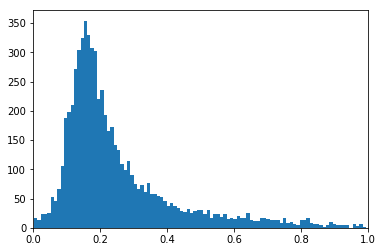

2011 44501 [ 0.075] 0.0 0.0


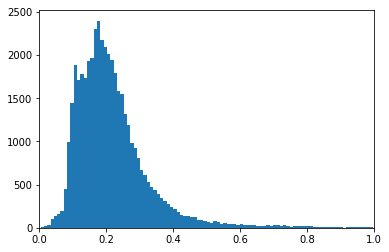

2012 46568 [ 0.07] 0.0 0.0


2013 39812 [ 0.078] 0.0 0.0


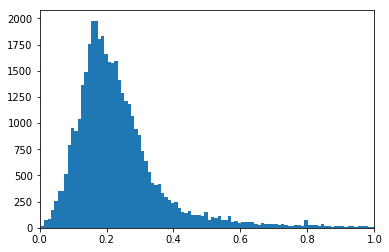

2014 9626 [ 0.02] 0.0 0.0


2015 79411 [ 0.109] 0.0 0.0


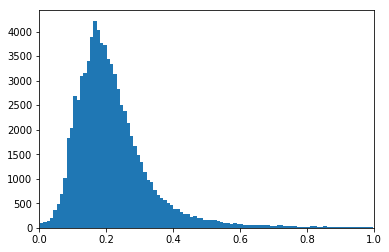

2016 98700 [ 0.15] 0.0 0.0


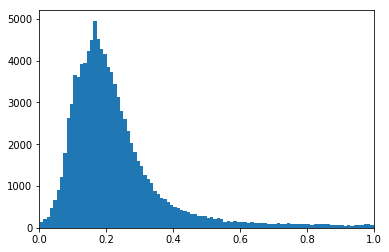

2017 68914 [ 0.188] 0.0 0.0


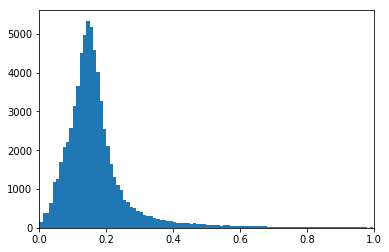

In [54]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [55]:
print """
    There are negative values for 2015. peak for the ratio is 0.2.
"""


    There are negative values for 2015. peak for the ratio is 0.2.

